In [1]:
import sys
sys.path.append("../src/")
import numpy as np
import pandas
import json
import ot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import glob
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import random
import tqdm
from tqdm import tqdm
import seaborn as sb
import scipy as sp
import topo_util
from topo_util import noisy_circle, noisy_disk
import sklearn as sk
import sklearn.decomposition
import math
import pd

/home/syz/miniconda3/envs/tpot/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def torus(n_samples,noise_level,radius):
    t = np.linspace(0,2*np.pi,n_samples)
    r = np.sqrt(radius*np.random.rand(n_samples))
    x = np.multiply(r,np.cos(t))
    y =  np.multiply(r,np.sin(t))
    noise = np.random.rand(n_samples,2)
    data = []
    for ii in range(n_samples):
        if r[ii] > 0.4:
            data.append([x[ii],y[ii], 0])
    noise = np.random.rand(len(data),3) 
    data = np.array(data) + noise_level*radius*noise
    return data

In [3]:
B = torus(400, 0.1,  1.5 )

In [4]:
data4 = noisy_disk(100, 0.1, 0, 0, 0.9)
data4 = [[2.6, el[0],el[1]+2] for el in data4]

data = noisy_circle(30, 0.1, 2, 0.7 ,0.5)
data = np.array([[el[0], 0, el[1]] for el in data])
for i in range(2,8):
    aaa = noisy_circle(35, 0.1, 2, 0 ,0.8)
    aaa = np.array([ [ (0.2 * i)+ (np.random.rand(1)[0]*0.2)+1, el[1],el[0] ] for el in aaa])
    data = np.concatenate([data,aaa])
data = np.concatenate([data, data4])  

data = [[el[1],el[2],-el[0]] for el in data]
data = np.array(data)
A = data

In [5]:
A.shape, B.shape


((340, 3), (352, 3))

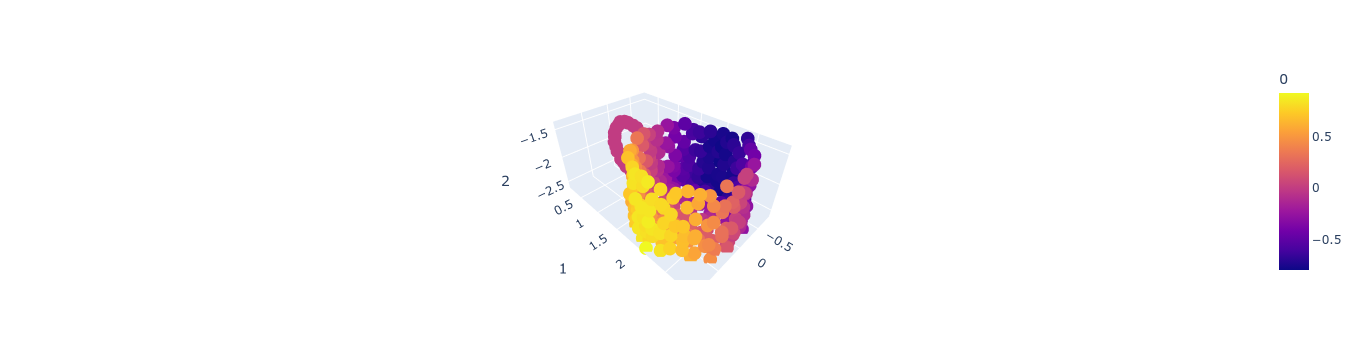

In [6]:
df = pandas.DataFrame(A)
fig = px.scatter_3d(df, x=0, y=1, z=2,  color = 0
)
fig.update_scenes(aspectmode='data')

fig.show()

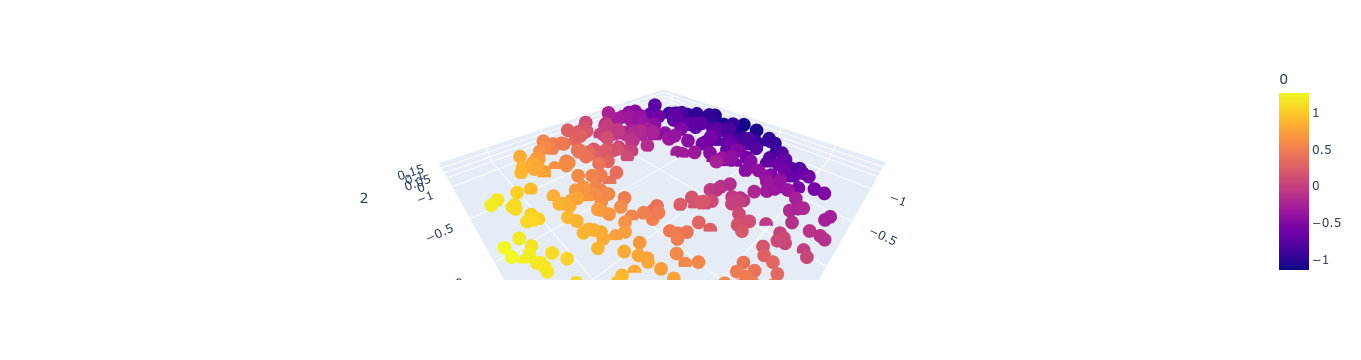

In [7]:
df = pandas.DataFrame(B)
fig = px.scatter_3d(df, x=0, y=1, z=2,  color = 0
)
fig.update_scenes(aspectmode='data')

fig.show()

In [8]:
C1 = sp.spatial.distance.cdist(A, A, "sqeuclidean")
C2 = sp.spatial.distance.cdist(B, B, "sqeuclidean")

C1 /= np.median(C1)
C2 /= np.median(C2)

In [9]:
p_dis = ot.unif(len(A))
q_dist = ot.unif(len(B))

gw0, log0 = ot.gromov.gromov_wasserstein(
    C1, C2, p_dis, q_dist, 'square_loss', verbose=True, log=True)
print('Gromov-Wasserstein distances: ' + str(log0['gw_dist']))

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.519873e+00|0.000000e+00|0.000000e+00
    1|1.234670e+00|2.309951e-01|2.852027e-01
    2|5.846386e-01|1.111851e+00|6.500313e-01
    3|3.044880e-01|9.200709e-01|2.801506e-01
    4|2.858828e-01|6.507985e-02|1.860521e-02
    5|2.835110e-01|8.365940e-03|2.371836e-03
    6|2.832306e-01|9.900213e-04|2.804043e-04
    7|2.831488e-01|2.889444e-04|8.181424e-05
    8|2.830984e-01|1.779808e-04|5.038606e-05
    9|2.830321e-01|2.342464e-04|6.629925e-05
   10|2.829197e-01|3.972177e-04|1.123807e-04
   11|2.827990e-01|4.269580e-04|1.207433e-04
   12|2.827159e-01|2.938292e-04|8.307019e-05
   13|2.826633e-01|1.860110e-04|5.257850e-05
   14|2.826089e-01|1.923744e-04|5.436671e-05
   15|2.825477e-01|2.169039e-04|6.128569e-05
   16|2.825055e-01|1.493426e-04|4.219011e-05
   17|2.824780e-01|9.711540e-05|2.743297e-05
   18|2.824530e-01|8.856996e-05|2.501685e-05
   19|2.823776e-01|2.669332e-04|7.537596e-05
It. 

In [10]:
def centre(i, pc):
    if i < 30:
        return  - pc[i][2]
    else:
        return pc[i][2] +1
    

color = np.array([centre(i, A) for i in range(len(A))] )

def handle(el):
    if el[1] < 1.3:
        return el[1]
    else:
        return el[1]+3

color = np.array([handle(A[i]) for i in range(len(A))] )

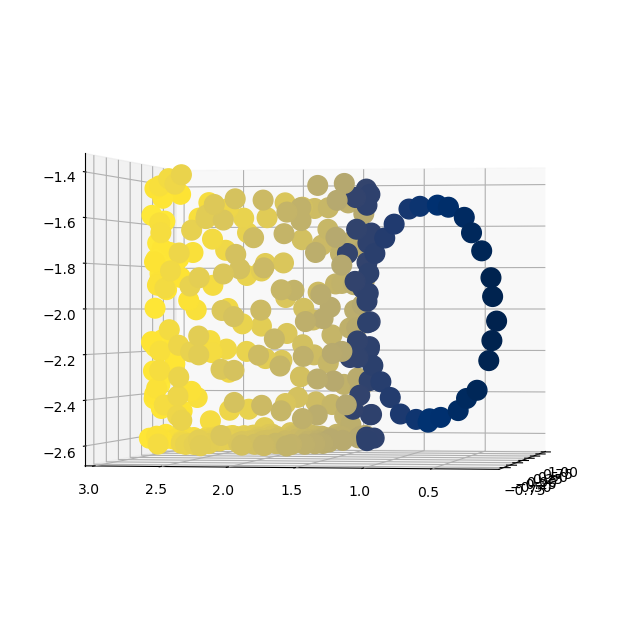

In [12]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

scat = ax.scatter(A[:,0],A[:,1],A[:,2], 
                    marker='o', 
                    s=200,
                    c = color,
                    cmap = 'cividis',
                    alpha= 1, vmax=max(color), vmin=min(color)
                 )
ax.view_init(elev=0, azim=190, roll=0)
plt.savefig('../outputs/mug.svg')

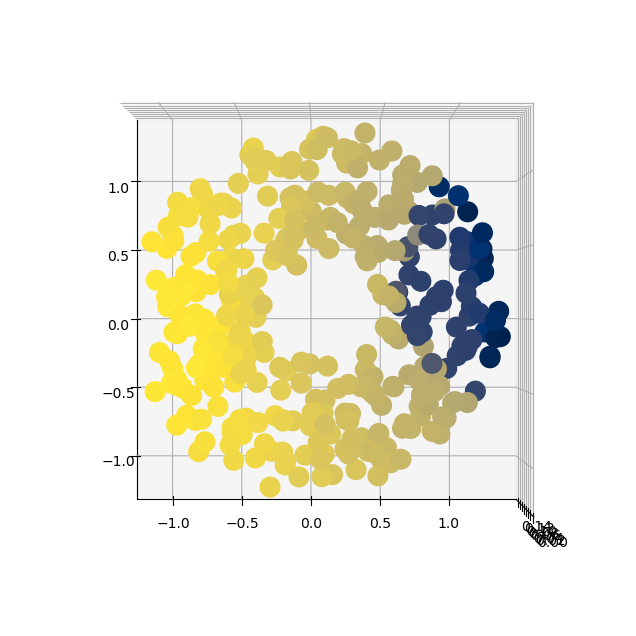

In [13]:
P = gw0.T / gw0.sum(axis=0)[:, np.newaxis]
p_gromov = np.matmul(P, color)

fig = plt.figure()

ax = fig.add_subplot(projection='3d')

scat = ax.scatter(B[:,0],B[:,1],B[:,2], 
                    marker='o', 
                    s=200,
                    c = p_gromov,
                    cmap = 'cividis',
                    alpha= 1, vmax=max(color), vmin=min(color))
ax.view_init(elev=270, azim=0, roll=0)
plt.savefig('../outputs/torus_GW.svg')

In [14]:
def PH(X):
    df = pandas.DataFrame()
    for ii in range(X.shape[1]):
        df['x_{}'.format(ii)] =  X[:,ii]
    df.to_csv("pointcloud.tsv", sep = '\t', index = False)
    !julia ../src/PH.jl 
    with open('PH.json','r') as f:
        dic = json.load(f)
    return dic  

In [15]:
H_all = [PH(x) for x in tqdm([A,B])]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:22<00:00, 11.41s/it]


In [16]:
df1 = topo_util.make_dataframe(H_all[0]["barcode"])
df2 = topo_util.make_dataframe(H_all[1]["barcode"])

In [17]:
import importlib
importlib.reload(pd)
import ot

p_spt = df1.iloc[:, 0:2].to_numpy()
q_spt = df2.iloc[:, 0:2].to_numpy()
p, q = pd.augmented_weights(p_spt, q_spt)
C = pd.augmented_cost(p_spt, q_spt)
pi = ot.emd(p, q, C)

In [18]:
import hypernetx as hnx
import tpot

/home/syz/miniconda3/envs/tpot/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [19]:
G_all = [hnx.Hypergraph({str(i) : k for (i, k) in enumerate(g['representatives'])}) for g in H_all]

In [20]:
y0, w0, v0 = topo_util.process_hg(G_all[0], A.shape[0])
y1, w1, v1 = topo_util.process_hg(G_all[1], B.shape[0])

In [21]:
# similarity with kernel
h = 0.25
K0 = topo_util.get_kernel(A, h)
L0 = topo_util.symmetric_laplacian(K0)
K0 /= K0.sum(-1).reshape(-1, 1)
K1 = topo_util.get_kernel(B, h)
L1 = topo_util.symmetric_laplacian(K1)
K1 /= K1.sum(-1).reshape(-1, 1)

In [22]:
y0_imputed = topo_util.impute_laplacian(y0, L0)
y1_imputed = topo_util.impute_laplacian(y1, L1) 

In [23]:
y0 = y0_imputed; y1 = y1_imputed;

In [24]:
C_v0 = sp.spatial.distance.cdist(A, A, metric = "sqeuclidean"); C_v0 /= np.mean(C_v0)
C_v0 = np.exp(-C_v0)
C_v1 = sp.spatial.distance.cdist(B, B, metric = "sqeuclidean"); C_v1 /= np.mean(C_v1)
C_v1 = np.exp(-C_v1)
C_pd = pd.augmented_cost(p_spt, q_spt); C_pd /= np.mean(C_pd)

Iteration 0,	 obj = 0.08595412835524079,	 obj_terms = {'coot': 0.02636435737639038, 'ot': 0.05224857337695224, 'gw': 0.007341197601898168}
is_converged, obj = 0.0859131136017282, obj_new = 0.08591311432899523


/tmp/ipykernel_696049/1513323641.py:13: RuntimeWarning:

invalid value encountered in divide



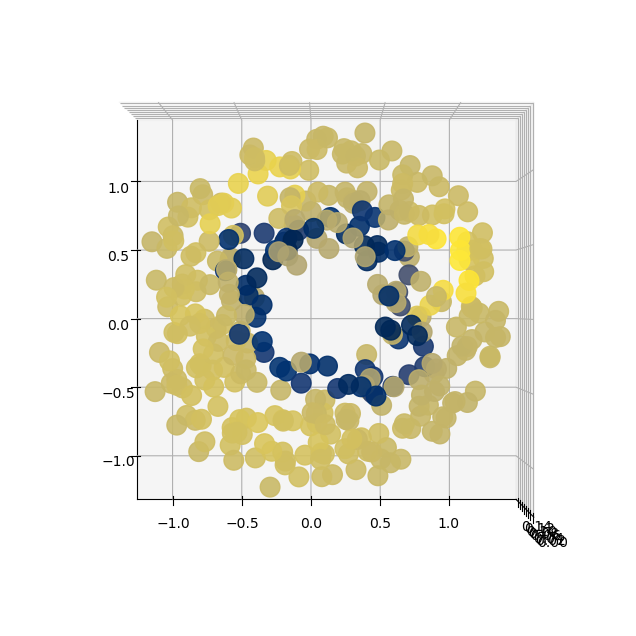

In [25]:
alpha = 0.1
beta = 5
v0 = p
v1 = q
pi_s, pi_f, _, = tpot.TPOT(y0, y1, w0, w1, v0, v1,
                          C_v0, C_v1, C_pd, 
                          alpha = alpha, beta = beta, iter = 500, 
                          eps_s = 0.05, eps_f = 0.05, 
                          solver = "sinkhorn", 
                          )
P = (pi_s / pi_s.sum(axis=-1)[:, np.newaxis])
Q = (pi_f[:-1, :-1] / pi_f[:-1, :-1].sum(axis=-1)[:, np.newaxis])
Q_pd = pi[:-1, :-1] / pi[:-1, :-1].sum(axis=-1)[:, np.newaxis]
Q[np.isnan(Q)] = 0
Q_pd[np.isnan(Q_pd)] = 0
P = (pi_s / pi_s.sum(axis=-1)[:, np.newaxis])
pp_to = np.matmul(P.T, color)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
scat = ax.scatter(B[:,0],B[:,1],B[:,2], 
                marker='o', 
                s=200,
                c = pp_to,
                cmap = 'cividis',
                alpha= 0.89, )

ax.view_init(elev=270, azim=0, roll=0)
plt.savefig('../outputs/mug_target_tpot_alpha{}_beta{}.svg'.format(alpha,beta))


In [26]:
sizes_p = 40 + np.zeros((len(p_spt)))
sizes_q = 40 + np.zeros((len(q_spt)))
sizes_p[-1] = 100
sizes_q[-1] = 100

color_p =  1+np.zeros((len(p_spt)))
color_q =  2+np.ones((len(q_spt)))

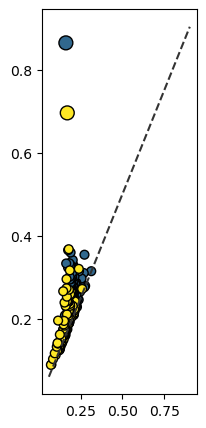

In [29]:
plt.figure(figsize = (2, 5))
pd.plot_pd(p, q, p_spt, q_spt, pi_f, color_p, color_q, sizes_p, sizes_q)
plt.savefig('../outputs/mug_diagrams.svg'.format(alpha,beta), dpi=300)

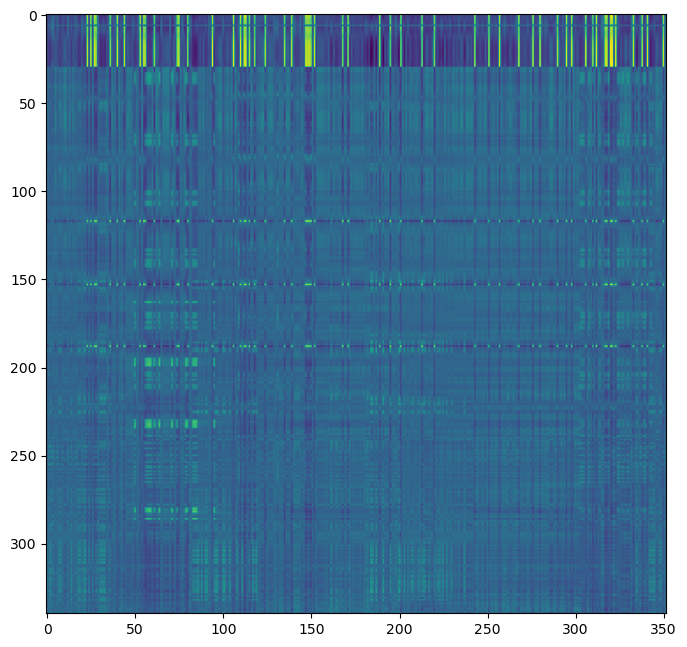

In [30]:
plt.imshow(np.log(pi_s[:,:]))